In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/Phoestia/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [2]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
from scipy import sparse as sp
from pyspark.mllib.feature import Normalizer

In [3]:
%matplotlib inline

In [4]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/Phoestia/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Data Visulation

## User Data

In [6]:
user_data = sc.textFile("u.user")
user_data.first()
user_data.take(5)


[u'1|24|M|technician|85711',
 u'2|53|F|other|94043',
 u'3|23|M|writer|32067',
 u'4|24|M|technician|43537',
 u'5|33|F|other|15213']

In [7]:
user_fields = user_data.map(lambda line: line.split("|"))
num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()
print "Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, num_genders, num_occupations, num_zipcodes)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


### Age Distribution

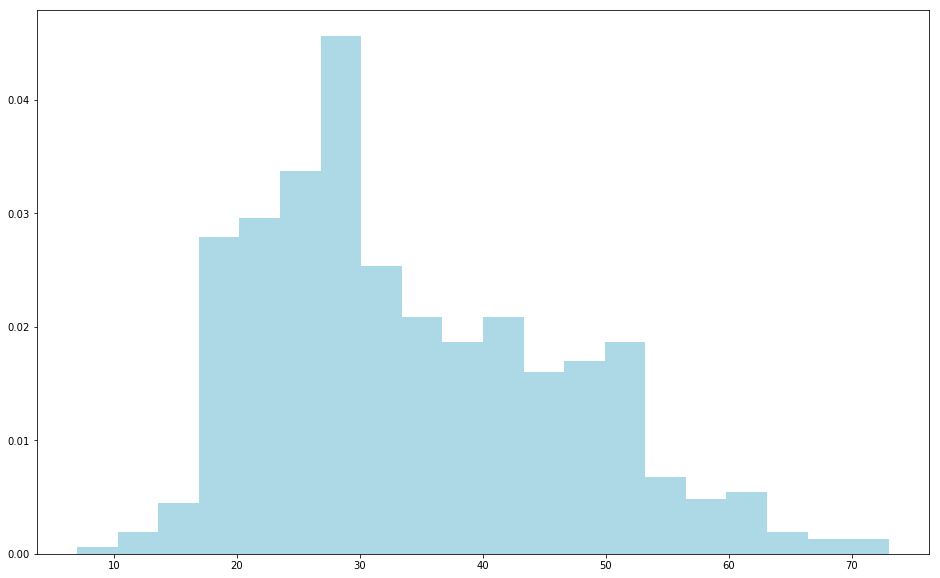

In [8]:
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages, bins=20, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

### Occupation Distribution



In [13]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()

x_axis1 = np.array([c[0] for c in count_by_occupation])

y_axis1 = np.array([c[1] for c in count_by_occupation])

print x_axis1

[u'administrator' u'retired' u'lawyer' u'none' u'student' u'technician'
 u'programmer' u'salesman' u'homemaker' u'executive' u'doctor'
 u'entertainment' u'marketing' u'writer' u'scientist' u'educator'
 u'healthcare' u'librarian' u'artist' u'other' u'engineer']


In [47]:
print y_axis1

[ 79  14  12   9 196  27  66  12   7  32   7  18  26  45  31  95  16  51
  28 105  67]


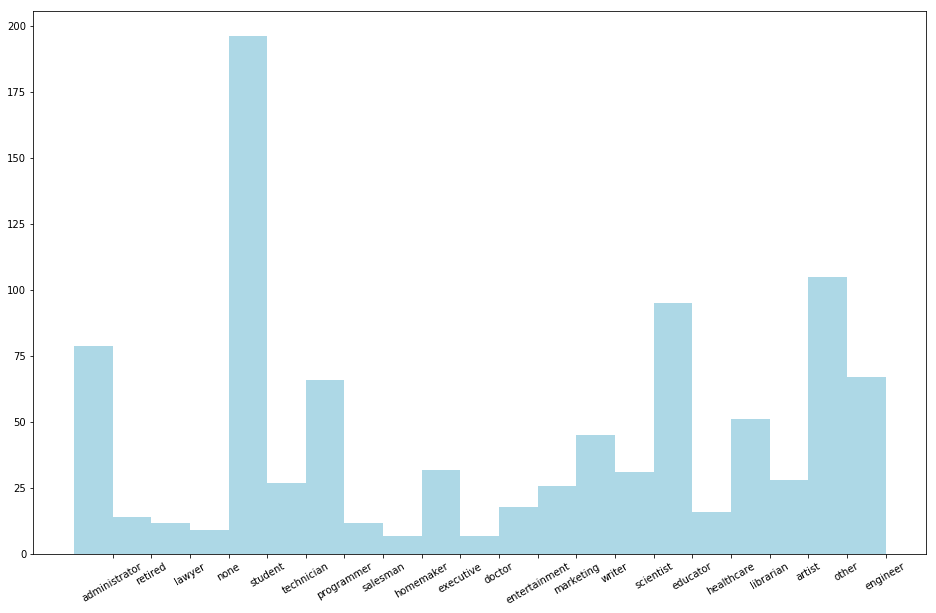

In [46]:
pos = np.arange(len(x_axis1))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis1)

plt.bar(pos, y_axis1, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [16]:
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print "Map-reduce approach:"
print dict(count_by_occupation2)
print ""
print "countByValue approach:"
print dict(count_by_occupation)

Map-reduce approach:
{u'administrator': 79, u'retired': 14, u'lawyer': 12, u'healthcare': 16, u'marketing': 26, u'executive': 32, u'scientist': 31, u'student': 196, u'technician': 27, u'librarian': 51, u'programmer': 66, u'salesman': 12, u'homemaker': 7, u'engineer': 67, u'none': 9, u'doctor': 7, u'writer': 45, u'entertainment': 18, u'other': 105, u'educator': 95, u'artist': 28}

countByValue approach:
{u'administrator': 79, u'writer': 45, u'retired': 14, u'lawyer': 12, u'doctor': 7, u'marketing': 26, u'executive': 32, u'none': 9, u'entertainment': 18, u'healthcare': 16, u'scientist': 31, u'student': 196, u'educator': 95, u'technician': 27, u'librarian': 51, u'programmer': 66, u'artist': 28, u'salesman': 12, u'other': 105, u'homemaker': 7, u'engineer': 67}


## Movie Data

In [17]:
movie_data = sc.textFile("u.item")
print movie_data.first()
num_movies = movie_data.count()
print "Movies: %d" % num_movies

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


In [18]:
def convert_year(x):
  try:
    return int(x[-4:])
  except:
    return 1900

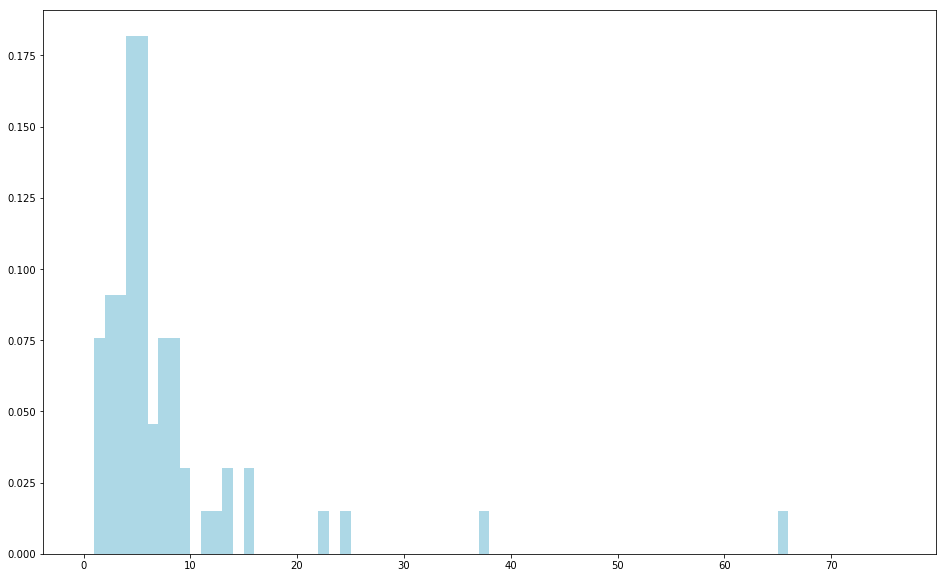

In [19]:
movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))

years_filtered = years.filter(lambda x: x != 1900)

movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
hist(values, bins=bins, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

## Rating Data

In [20]:
rating_data = sc.textFile("u.data")
print rating_data.first()
num_ratings = rating_data.count()
print "Ratings: %d" % num_ratings

196	242	3	881250949
Ratings: 100000


In [21]:
rating_data = rating_data.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print "Min rating: %d" % min_rating
print "Max rating: %d" % max_rating
print "Average rating: %2.2f" % mean_rating
print "Median rating: %d" % median_rating
print "Average # of ratings per user: %2.2f" % ratings_per_user
print "Average # of ratings per movie: %2.2f" % ratings_per_movie

Min rating: 1
Max rating: 5
Average rating: 3.00
Median rating: 4
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00


#### Max rating: 5
Average rating: 3.00
Median rating: 4
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00

In [22]:
ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

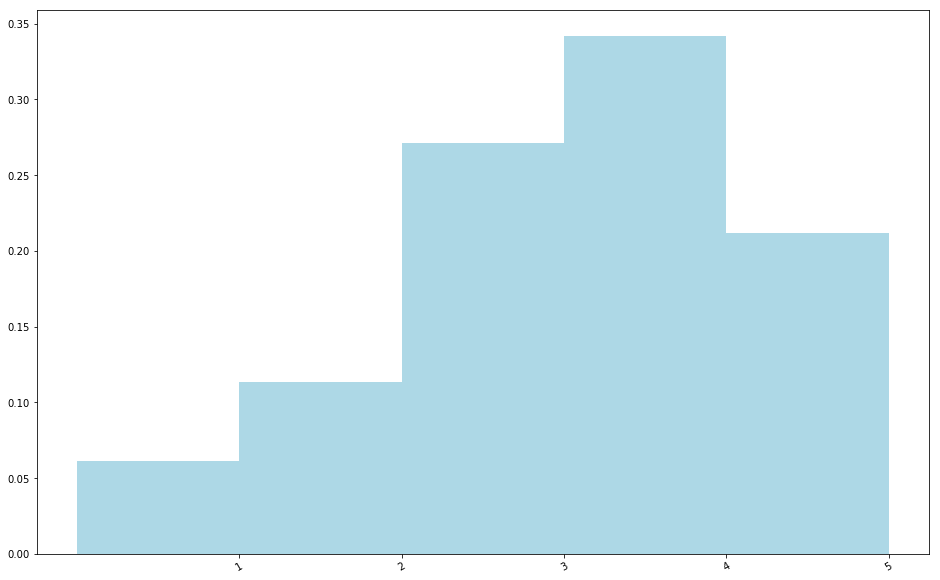

In [23]:
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

### Rating Group Distribution

In [24]:
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey()

user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
user_ratings_byuser.take(10)

[(2, 62),
 (4, 24),
 (6, 211),
 (8, 59),
 (10, 184),
 (12, 51),
 (14, 98),
 (16, 140),
 (18, 277),
 (20, 48)]

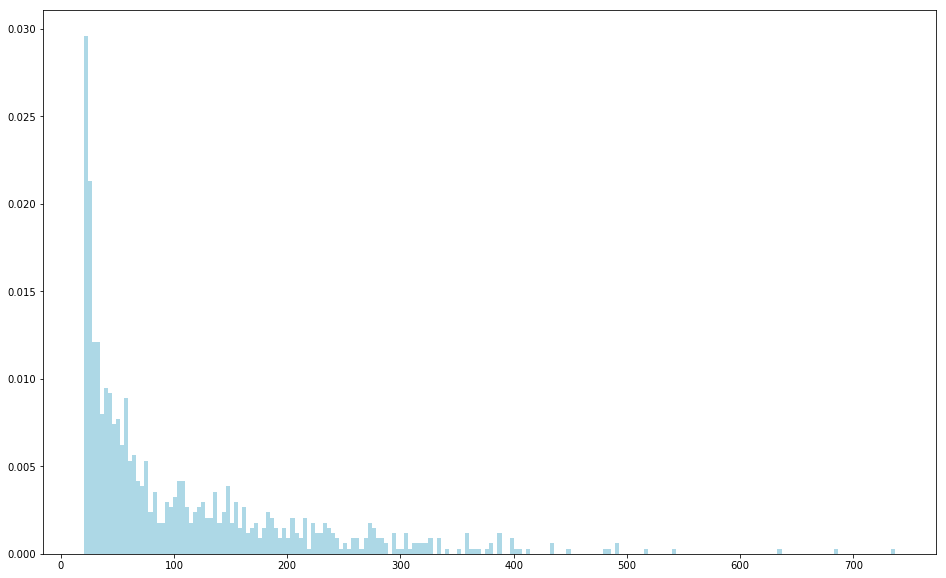

In [25]:
user_ratings_byuser_local = user_ratings_byuser.map(lambda (k, v): v).collect()
hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

# 2.  Features

In [26]:
all_occupations = user_fields.map(lambda fields: fields[3]). distinct().collect()
all_occupations.sort()

In [27]:
idx = 0
all_occupations_dict = {}
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1
print "Encoding of 'doctor': %d" % all_occupations_dict['doctor']
print "Encoding of 'programmer': %d" % all_occupations_dict['programmer']

Encoding of 'doctor': 2
Encoding of 'programmer': 14


In [58]:
#Time stamp => classification feature
rating_data = sc.textFile("u.data" )
rating_fields = rating_data.map(lambda line: line.split('\t'))
timestamps = rating_fields.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: datetime.fromtimestamp(ts).hour)
times_of_day_dict = {}
for hour in range(24):
    if hour in range(7, 12):
        times_of_day_dict[hour] = "morning"
    elif hour in range(12, 14):
        times_of_day_dict[hour] = "lunch"
    elif hour in range(14, 18):
        times_of_day_dict[hour] = "afternoon"
    elif hour in range(18, 23):
        times_of_day_dict[hour] = "evening"
    else:
        times_of_day_dict[hour] = "night"
time_of_day = hour_of_day.map(lambda hour: times_of_day_dict[hour])
print
print("Converting timestamps to features.")
print(hour_of_day.take(5))
print(time_of_day.take(5))



Converting timestamps to features.
[10, 14, 2, 0, 0]
['morning', 'afternoon', 'night', 'night', 'night']


In [61]:
# Extract text feature, using bag-of-word method.
def extract_title(raw):
    grps = re.search("\((\w+)\)", raw)
    if grps:
        return raw[:grps.start()].strip()
    else:
        return raw
movie_data = sc.textFile("u.item" )
movie_fields = movie_data.map(lambda line: line.split('|'))
raw_titles = movie_fields.map(lambda fields: fields[1])
print
print("Remove year information in '()'")
for raw_title in raw_titles.take(5):
    print(extract_title(raw_title))
movie_titles = raw_titles.map(extract_title)
title_terms = movie_titles.map(lambda line: line.split(' '))
print
print("Split words.")
print(title_terms.take(5))


Remove year information in '()'
Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat

Split words.
[[u'Toy', u'Story'], [u'GoldenEye'], [u'Four', u'Rooms'], [u'Get', u'Shorty'], [u'Copycat']]


In [62]:
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
all_terms_dict = {}
for i, term in enumerate(all_terms):
    all_terms_dict[term] = i
print
print("Total number of terms: %d" % len(all_terms_dict))


Total number of terms: 2645


In [64]:
#from scipy import sparse as sp
def create_vector(terms, term_dict):
    num_terms = len(term_dict)
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda 
    terms: create_vector(terms, all_terms_bcast.value))
print
print("The first five terms of converted sparse matrix of title")
print(term_vectors.take(5))



The first five terms of converted sparse matrix of title
[<1x2645 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Column format>, <1x2645 sparse matrix of type '<type 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>, <1x2645 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Column format>, <1x2645 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Column format>, <1x2645 sparse matrix of type '<type 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>]


# 3. Regularization

In [29]:
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x:\n%s" % normalized_x
print "2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


# Use MLlib to Normalizer

In [30]:
from pyspark.mllib.feature import Normalizer
normalizer = Normalizer()
vector =sc.parallelize([x])

In [31]:
normalized_x_mllib = normalizer.transform(vector).first().toArray()

In [32]:
print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x MLlib:\n%s" % normalized_x_mllib
print "2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000


In [34]:
rating_data.first()


[u'196', u'242', u'3', u'881250949']

In [59]:
np.random.seed(42)
x = np.random.randn(4)
norm_x = np.linalg.norm(x)
normalized_x = x / norm_x
print
print("x: %s" % x)
print("2-norm of x: %.4f" % norm_x)
print("normalized x: %s" % normalized_x)
normalizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()
print("MLlib normalized x: %s" % normalized_x)



x: [ 0.49671415 -0.1382643   0.64768854  1.52302986]
2-norm of x: 1.7335
normalized x: [ 0.28654116 -0.07976099  0.37363426  0.87859535]
MLlib normalized x: [ 0.28654116 -0.07976099  0.37363426  0.87859535]


In [67]:
import org.apache.spark.SparkContext
import org.apache.spark.SparkContext._
import org.apache.spark.mllib.recommendation.ALS
import org.apache.spark.mllib.recommendation.Rating
import org.jblas.DoubleMatrix
import org.apache.spark.mllib.evaluation.RegressionMetrics
import org.apache.spark.mllib.evaluation.RankingMetrics

object ScalaApp {

  def main(args: Array[String]) {
    val sc = new SparkContext("local[2]", "First Spark App")
    sc.setLogLevel("ERROR")
    val rawData = sc.textFile("data/u.data")
    val rawRatings = rawData.map(_.split("\t").take(3))
    val ratings = rawRatings.map {case Array(user, movie, rating) => Rating(user.toInt, movie.toInt, rating.toDouble)}
    val model = ALS.train(ratings, 50, 10, 0.01)
    println(model.userFeatures.count)
    println(model.userFeatures.take(1))
    // Get rating for specific user and movie
    println(model.predict(196, 242))
    // Make recommendations to user
    val userId = 789
    val K = 5
    val topKRecs = model.recommendProducts(userId, K)
    println(topKRecs.mkString("\n"))
    // Check the recommendation movies' name
    val movies = sc.textFile("data/u.item")
    val titles = movies.map(line => line.split("\\|")).map(fields => (fields(0).toInt, fields(1))).collectAsMap()
    val moviesForUser = ratings.keyBy(_.user).lookup(789)
    println("User " + userId +"'s favorite movies:")
    moviesForUser.sortBy(-_.rating).take(5).map(rating => (titles(rating.product), rating.rating)).foreach(println)
    println("Movies recommended to user " + userId)
    topKRecs.map(rating => (titles(rating.product), rating.rating)).foreach(println)
    // Similar item recommendation
    def cosineSimilarity(vec1: DoubleMatrix, vec2: DoubleMatrix): Double = {
      vec1.dot(vec2) / (vec1.norm2() * vec2.norm2())
    }
    val itemId = 567
    val itemFactor = model.productFeatures.lookup(itemId).head
    val itemVector = new DoubleMatrix(itemFactor)
    println(cosineSimilarity(itemVector, itemVector))
    val sims = model.productFeatures.map {case (id, factor) =>
      val factorVector = new DoubleMatrix(factor)
      val sim = cosineSimilarity(factorVector, itemVector)
      (id, sim)
    }
    val sortedSims = sims.top(K)(Ordering.by[(Int, Double), Double] {case (id, similarity) => similarity})
    println(sortedSims.mkString("\n"))
    // Check the similar movies' name
    println("Item number " + itemId + "'s name:")
    println(titles(itemId))
    println("Names of similar movies:")
    println(sortedSims.map {case (id, similarity) => (titles(id), similarity)}.mkString("\n"))
    // Calculate MSE
    val usersProducts = ratings.map {case Rating(user, product, rating) => (user, product)}
    val predictions = model.predict(usersProducts).map {case Rating(user, product, rating) => ((user, product), rating)}
    val ratingsAndPredictions = ratings.map {case Rating(user, product, rating) =>
      ((user, product), rating)}.join(predictions)
    val MSE = ratingsAndPredictions.map {
      case ((user, product), (actual, predicted)) => math.pow((actual - predicted), 2)
      }.reduce((x, y) => x + y) / ratingsAndPredictions.count
    println("MSE = " + MSE)
    println("RMSE = " + math.sqrt(MSE))
    // Calculate MSE with MLlib
    val predictedAndTrue = ratingsAndPredictions.map {
      case ((user, product), (actual, predicted)) => (actual, predicted)}
    val regressionMetrics = new RegressionMetrics(predictedAndTrue)
    println("MLlib MSE = " + regressionMetrics.meanSquaredError)
    println("MLlib RMSE = " + regressionMetrics.rootMeanSquaredError)
    // Calculate MAP with MLlib
    val userMovies = ratings.map{ case Rating(user, product, rating) => (user, product) }.groupBy(_._1)
    val itemFactors = model.productFeatures.map { case (id, factor) => factor }.collect()
    val itemMatrix = new DoubleMatrix(itemFactors)
    val imBroadcast = sc.broadcast(itemMatrix)
    val allRecs = model.userFeatures.map{ case (userId, array) =>
      val userVector = new DoubleMatrix(array)
      val scores = imBroadcast.value.mmul(userVector)
      val sortedWithId = scores.data.zipWithIndex.sortBy(-_._1)
      val recommendedIds = sortedWithId.map(_._2 + 1).toSeq
      (userId, recommendedIds)
    }
    val predictedAndTrueForRanking = allRecs.join(userMovies).map{ case (userId, (predicted, actualWithIds)) =>
      val actual = actualWithIds.map(_._2)
      (predicted.toArray, actual.toArray)
    }
    val rankingMetrics = new RankingMetrics(predictedAndTrueForRanking)
    println("Mean Average Precision = " + rankingMetrics.meanAveragePrecision)
  }
}

SyntaxError: invalid syntax (<ipython-input-67-bbb64857bf70>, line 9)